In [44]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import geopandas as gpd

from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import seaborn as sns




%matplotlib inline

import geojson

import json
import datetime
from datetime import timedelta


from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = [10, 10]
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

pd.set_option('display.float_format', '{:.2f}'.format)


In [45]:
# visit_count_total=pd.read_csv('../data_save/visit_count_ori.csv').drop(columns=['Unnamed: 0'])
visit_count_total=pd.read_csv('../data_save/visit_count_total.csv').drop(columns=['Unnamed: 0'])

In [46]:
acs_data=pd.read_csv('../data_save/acs.csv')
print(acs_data.columns)
columns_1=['average_car','tract_id',
           'pctWhite','pctBlack',"pctIndian","pctAsian","pctHispanic",
           "pctPoverty","pctVacant","pctBachelors",
           "MedHHInc",'MedRent','income_quantile'
          ]
acs=acs_data[columns_1]

Index(['Unnamed: 0', 'NAME', 'GEO_ID', 'total_pop', 'Hispanic', 'Whites', 'Black', 'Indian', 'Asian', 'FemaleBachelors', 'MaleBachelors', 'TotalPoverty', 'TotalVacant', 'TotalUnit', 'MedRent', 'MedHHInc', 'NoCar', 'OneCar', 'TwoCar', 'ThreeCar', 'FourMoreCar', 'TotalHousehold', 'state', 'county', 'tract', 'tract_id', 'income_quantile', 'pctWhite', 'pctBlack', 'pctIndian', 'pctAsian', 'pctHispanic', 'pctVacant', 'pctBachelors', 'pctPoverty', 'average_car'], dtype='object')


In [47]:
mobility_acs=pd.merge(visit_count_total, acs,how='inner',left_on=['tract_id'],right_on=['tract_id'])
mobility_acs.head()

,tract_id,mar_19,mar_20,mar_21,20_19,21_20,nor_20_19,nor_21_20,average_car,pctWhite,pctBlack,pctIndian,pctAsian,pctHispanic,pctPoverty,pctVacant,pctBachelors,MedHHInc,MedRent,income_quantile
0,36005000200,835,451,493,-384,42,-0.46,0.09,1.03,0.01,0.20,0.00,0.02,0.02,0.22,0.10,0.00,51100,1454,Mid
1,36005000400,3986,1970,2008,-2016,38,-0.51,0.02,1.21,0.07,0.23,0.00,0.02,0.02,0.08,0.06,0.01,78409,1241,Mid
2,36005001600,337,119,81,-218,-38,-0.65,-0.32,0.60,0.04,0.35,0.00,0.01,0.01,0.26,0.02,0.01,34093,953,Bot
3,36005001900,1555,1369,766,-186,-603,-0.12,-0.44,0.42,0.11,0.30,0.00,0.02,0.02,0.27,0.08,0.01,45156,1139,Bot
4,36005002300,1813,1309,700,-504,-609,-0.28,-0.47,0.19,0.00,0.28,0.00,0.00,0.00,0.39,0.00,0.00,18688,436,Bot


In [48]:
url='https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
r_1=requests.get(url)
features_1 = geojson.loads(r_1.text)

from shapely.geometry import shape, Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

GEOID,geometry,BoroName=[],[],[]

for e in features_1['features']: 
    GEOID.append(e['properties']["GEOID"])
    BoroName.append(e['properties']["BoroName"])

    ps = shape(e['geometry'])
    geometry.append(
        MultiPolygon(ps) if isinstance(ps, list) else ps
    )

boundary = pd.DataFrame([GEOID,geometry,BoroName]).T
boundary.columns=['tract_id','geometry','borough']
boundary['tract_id']=boundary['tract_id'].str[:11].astype('int64')


In [49]:
df=pd.DataFrame(pd.merge(mobility_acs, boundary,how='inner',left_on=['tract_id'],right_on=['tract_id']))
print(df.isnull().sum())
mobility_acs_total= df.replace({np.nan:0,-np.inf:-1,np.inf:1})
mobility_acs_total.to_csv('../data_save/regression/visit_count_inflow.csv')
mobility_acs_total_gdf=gpd.GeoDataFrame(mobility_acs_total, geometry='geometry', crs="EPSG:4326")
mobility_acs_total.head()
print('visit_count_merge_gdf.shape',mobility_acs_total.shape)
print(mobility_acs_total.isnull().values.any())

tract_id            0
mar_19              0
mar_20              0
mar_21              0
20_19               0
21_20               0
nor_20_19           0
nor_21_20          12
average_car         0
pctWhite            0
pctBlack            0
pctIndian           0
pctAsian            0
pctHispanic         0
pctPoverty          0
pctVacant           0
pctBachelors        0
MedHHInc            0
MedRent             0
income_quantile     0
geometry            0
borough             0
dtype: int64
visit_count_merge_gdf.shape (1140, 22)
False


In [50]:
mobility_acs_total_gdf.head()


,tract_id,mar_19,mar_20,mar_21,20_19,21_20,nor_20_19,nor_21_20,average_car,pctWhite,pctBlack,pctIndian,pctAsian,pctHispanic,pctPoverty,pctVacant,pctBachelors,MedHHInc,MedRent,income_quantile,geometry,borough
0,36005000200,835,451,493,-384,42,-0.46,0.09,1.03,0.01,0.20,0.00,0.02,0.02,0.22,0.10,0.00,51100,1454,Mid,"POLYGON ((-73.85652 40.80525, -73.85653 40.805...",Bronx
1,36005000400,3986,1970,2008,-2016,38,-0.51,0.02,1.21,0.07,0.23,0.00,0.02,0.02,0.08,0.06,0.01,78409,1241,Mid,"POLYGON ((-73.84611 40.81311, -73.84647 40.812...",Bronx
2,36005001600,337,119,81,-218,-38,-0.65,-0.32,0.60,0.04,0.35,0.00,0.01,0.01,0.26,0.02,0.01,34093,953,Bot,"POLYGON ((-73.85514 40.82244, -73.85497 40.821...",Bronx
3,36005002300,1813,1309,700,-504,-609,-0.28,-0.47,0.19,0.00,0.28,0.00,0.00,0.00,0.39,0.00,0.00,18688,436,Bot,"POLYGON ((-73.92289 40.80911, -73.92324 40.808...",Bronx
4,36005002500,69,42,32,-27,-10,-0.39,-0.24,0.25,0.04,0.24,0.00,0.00,0.00,0.38,0.06,0.00,23115,815,Bot,"POLYGON ((-73.91750 40.80682, -73.91765 40.806...",Bronx


In [51]:
columns_2=[
           'tract_id', 'borough',
           'mar_19', 'mar_20', 'mar_21', '20_19', '21_20', 
           'nor_20_19', 'nor_21_20', 
           'average_car', 
           'pctWhite', 'pctBlack', 'pctIndian', 'pctAsian', 'pctHispanic', 
           'pctPoverty', 'pctVacant', 'pctBachelors', 'MedHHInc', 'MedRent', 
          ]


In [52]:
# write data to geojson 
import shapely
def df_to_geojson(df, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Polygon',
                               'coordinates':[]}}
        
        feature['geometry']= shapely.geometry.mapping(row.geometry)
        for prop in columns_2:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

geojson =df_to_geojson(mobility_acs_total_gdf)

from geojson import Point, Feature, FeatureCollection, dump

with open('../data_save/regression/visit_count_inflow.geojson', 'w') as f:
   dump(geojson, f)
    

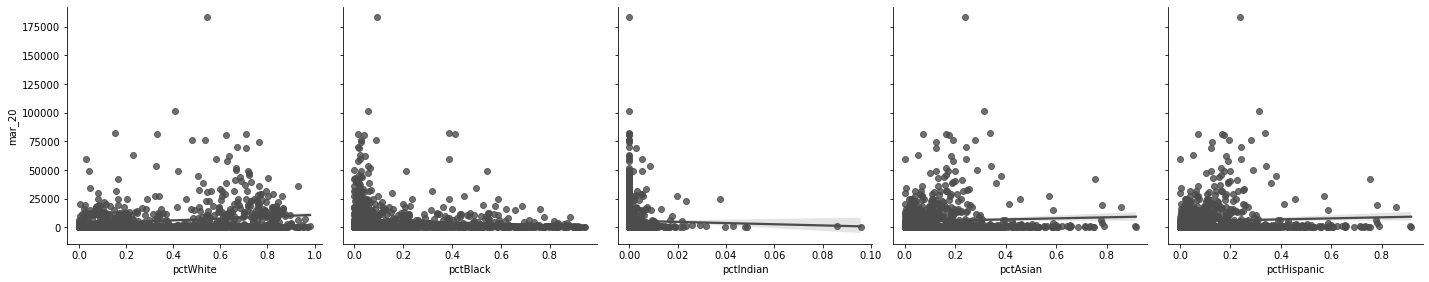

In [60]:
columns_3=[       
           'pctWhite', 'pctBlack', 'pctIndian', 'pctAsian', 'pctHispanic', 
            ]

g = sns.PairGrid(mobility_acs_total, y_vars=["mar_20"], x_vars=columns_3, height=4)
g.map(sns.regplot, color=".3")
g.savefig('g.png')
# g.set(ylim=(-1, 5))

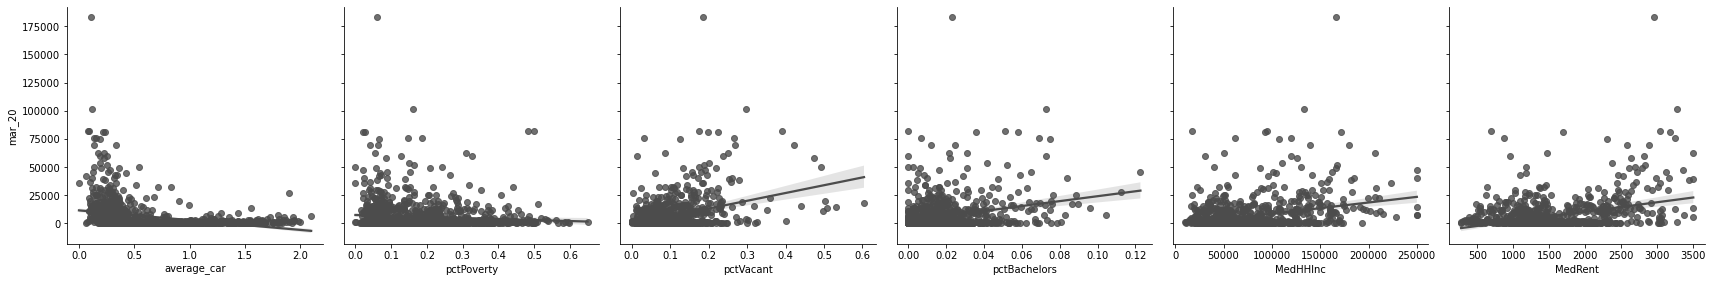

In [61]:
columns_4 = ['average_car', 'pctPoverty', 'pctVacant', 'pctBachelors', 'MedHHInc', 'MedRent']

g = sns.PairGrid(mobility_acs_total, y_vars=["mar_20"], x_vars=columns_4, height=4)
g.map(sns.regplot, color=".3")
# g.set(ylim=(-1, 5))


              average_car  pctPoverty  pctVacant  pctBachelors  MedHHInc  MedRent
average_car          1.00       -0.43      -0.18         -0.21      0.14    -0.06
pctPoverty          -0.43        1.00      -0.22         -0.17     -0.72    -0.58
pctVacant           -0.18       -0.22       1.00          0.21      0.42     0.45
pctBachelors        -0.21       -0.17       0.21          1.00      0.27     0.40
MedHHInc             0.14       -0.72       0.42          0.27      1.00     0.81
MedRent             -0.06       -0.58       0.45          0.40      0.81     1.00


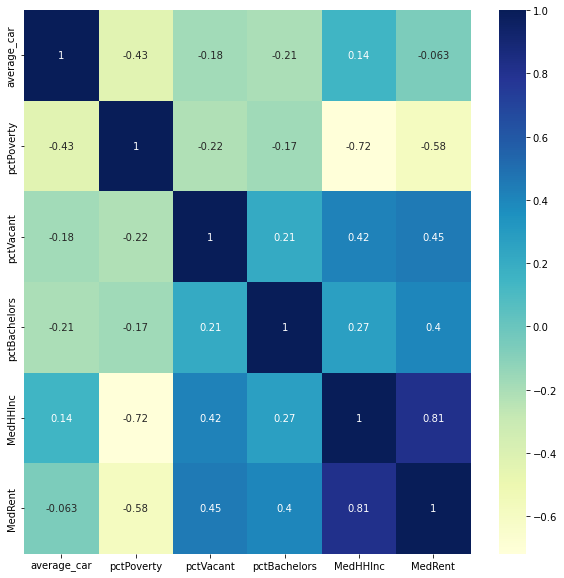

In [55]:
print(mobility_acs_total[columns_4].corr())
  
# plotting correlation heatmap
dataplot = sns.heatmap(mobility_acs_total[columns_4].corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

             pctWhite  pctBlack  pctIndian  pctAsian  pctHispanic
pctWhite         1.00     -0.62      -0.02     -0.01        -0.01
pctBlack        -0.62      1.00      -0.02     -0.40        -0.40
pctIndian       -0.02     -0.02       1.00      0.06         0.06
pctAsian        -0.01     -0.40       0.06      1.00         1.00
pctHispanic     -0.01     -0.40       0.06      1.00         1.00


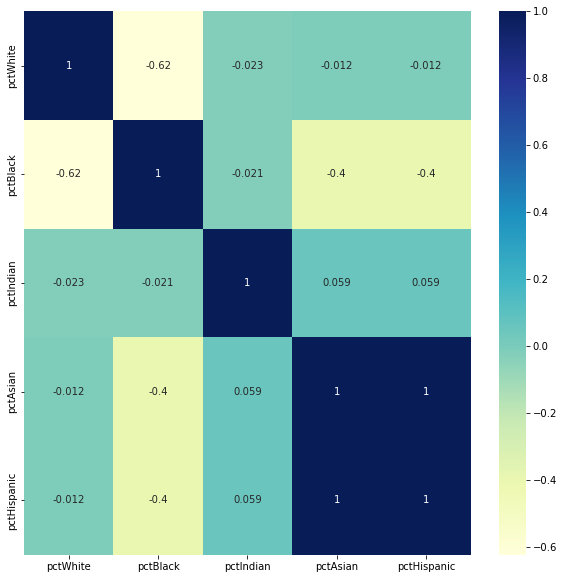

In [56]:
print(mobility_acs_total[columns_3].corr())
  
# plotting correlation heatmap
dataplot = sns.heatmap(mobility_acs_total[columns_3].corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()